In [1]:
from sklearn.model_selection import train_test_split
import glob
import shutil
import os

In [2]:
# Get the list of all .txt and .tif files
txt_files = glob.glob('/mnt/d/patches/*.txt')
tif_files = [f.replace('.txt', '.tif') for f in txt_files]

# Split the files into two sets for class labels proportion use stratify
txt_train, txt_test, tif_train, tif_test = train_test_split(txt_files, tif_files, test_size=0.2,random_state=1004)

# Create directories for the train and test sets
os.makedirs('/mnt/d/yolov5/dataset2/train', exist_ok=True)#'/mnt/d/dataset/images/umbra/train'
os.makedirs('/mnt/d/yolov5/dataset2/valid', exist_ok=True)#'/mnt/d/dataset/images/umbra/valid'

# Move the files to the corresponding directories
for file in txt_train + tif_train:
    shutil.copy(file, '/mnt/d/yolov5/dataset2/train')

for file in txt_test + tif_test:
    shutil.copy(file, '/mnt/d/yolov5/dataset2/valid')

In [4]:
from osgeo import gdal

In [3]:
import os

directory_path = "/mnt/d/task_add_gligen_annotations_2024_09_09_05_40_19_yolo 1.1/obj_train_data/"
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

for file_name in files:
    file_path = os.path.join(directory_path, file_name)
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    modified_lines = []
    for line in lines:
        parts = line.split()
        if parts:
            if parts[0] == '6':
                parts[0] = 'movingairplane'
            modified_lines.append(' '.join(parts))
    
    with open(file_path, 'w') as file:
        file.write('\n'.join(modified_lines))

In [6]:
import os

directory_path = '/mnt/e/detect_target/data/paper_data/new_train_data/'
# Get the list of .png files in the directory
png_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]

# Convert .png files to .tif files
for png_file in png_files:
    png_file_path = os.path.join(directory_path, png_file)
    tif_file_path = os.path.join(directory_path, png_file.replace('.png', '.tif'))
    os.rename(png_file_path, tif_file_path)

In [2]:
import os

folder_path = "/mnt/e/snu/2024/mingun/formating/obj_train_data/"  # Replace with the path to your folder
output_file = "/mnt/e/snu/2024/mingun/formating/train.txt"  # Replace with the desired output file path

# Get the list of files in the folder
files = os.listdir(folder_path)

# Open the output file in write mode
with open(output_file, "w") as f:
    # Write the formatted file paths to the output file
    for file in files:
        file_path = os.path.join("/data/obj_train_data", file)
        f.write(file_path + "\n")

In [11]:
directory_path = "/mnt/e/snu/2024/mingun/formating/job_19_dataset_2024_08_05_14_23_02_yolo 1.1/obj_train_data/"
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

for file_name in files:
    file_path = os.path.join(directory_path, file_name)
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    modified_lines = []
    for line in lines:
        parts = line.split()
        if parts:
            parts[0] = str(int(parts[0]) + 23)
            modified_lines.append(' '.join(parts))
    
    with open(file_path, 'w') as file:
        file.write('\n'.join(modified_lines))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [3]:
import cv2
import numpy as np
from itertools import repeat
from pathlib import Path
import os
import glob
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng', 'webp', 'mpo']  # acceptable image suffixes

def division_testset(input_band=None, img_size=640):
    img_list, div_coord = [], []
    
    # 분할 구간 설정
    h, w = input_band.shape[:2]

    hd = [x for x in range(0, h, img_size-100)]
    wd = [x for x in range(0, w, img_size-100)]
    hd[-1] = h - img_size; wd[-1] = w - img_size
        
    for h_id, div_h in enumerate(hd[:-1]):
        for w_id, div_w in enumerate(wd[:-1]):
            # 분할된 이미지의 좌표
            x1, y1 = div_w, div_h
            x2, y2 = div_w+img_size, div_h+img_size

            dw = x2-x1; dh = y2-y1
            # Crop
            crop = input_band[y1:y2, x1:x2]
            img_list.append(crop)
            div_coord.append([dw, dh, div_w, div_h])

    return img_list, div_coord

def band_to_rgb(tif_path):

    print(tif_path)
    raster = gdal.Open(tif_path)

    image_array = np.array(raster.GetRasterBand(1).ReadAsArray(),np.uint8)
    rgb_image = image_array.astype(np.uint8)

    return np.dstack((rgb_image,rgb_image,rgb_image))

class LoadSAR:
    def __init__(self, path, img_size=640, stride=32, save_dir=''):
        p = str(Path(path).absolute())  # os-agnostic absolute path
        if '*' in p:
            files = sorted(glob.glob(p, recursive=True))  # glob
        elif os.path.isdir(p):
            files = sorted(glob.glob(os.path.join(p, '*.*')))  # dir
        elif os.path.isfile(p):
            files = [p]  # files
        else:
            raise Exception(f'ERROR: {p} does not exist')

        images = [x for x in files if x.split('.')[-1].lower() in img_formats]
        ni = len(images)
        
        self.img_size = img_size
        self.stride = stride
        self.files = images
        self.nf = ni  # number of files
        self.mode = 'image'
        self.save_dir = save_dir
        
        assert self.nf > 0, f'No images found in {p}. ' \
                            f'Supported formats are:\nimages: {img_formats}'
    
    def __iter__(self):
        self.count = 0  # Initialize count here
        return self
                            
    def __next__(self):
        if self.count == self.nf:
            raise StopIteration
        path = self.files[self.count]

        # Read image
        self.count += 1
        
        # Convert to RGB (img, img, img)
        rgb_band = band_to_rgb(path)

        # Make patches for test
        div_img_list, div_coord = division_testset(input_band=rgb_band, img_size=self.img_size)
        
        return path, rgb_band, div_img_list, div_coord
        
    def __len__(self):
        return self.nf  # number of files

In [4]:
from osgeo import gdal

In [6]:
dataset = LoadSAR(path='/mnt/d/yolov5/test/2023-07-29-13-37-17_UMBRA-05/2023-07-29-13-37-17_UMBRA-05_GEC.tif',img_size=512)

In [8]:
for path, rgb_band, div_img_list, div_coord in dataset:  
    # 테스트 이미지를 1/div_num 만큼 width, height를 분할하고, 크롭된 이미지와 위치좌표를 반환
    for d_id, img0 in enumerate(div_img_list):
        div_x, div_y = div_coord[d_id][0], div_coord[d_id][1]
        print(img0.shape, div_x, div_y)

/mnt/d/yolov5/test/2023-07-29-13-37-17_UMBRA-05/2023-07-29-13-37-17_UMBRA-05_GEC.tif
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3) 512 512
(512, 512, 3)

In [9]:
# 이터레이터 초기화
iter_dataset = iter(dataset)

In [10]:
path, rgb_band, div_img_list, div_coord=dataset.__next__()

/mnt/d/yolov5/test/2023-07-29-13-37-17_UMBRA-05/2023-07-29-13-37-17_UMBRA-05_GEC.tif


: 

: 

In [17]:
directory_path = "/mnt/e/snu/2024/mingun/formating/task_oiltank2_dataset_2024_08_05_14_41_51_yolo 1.1/obj_train_data/"
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

for file_name in files:
    if file_name.endswith(".txt"):
        file_path = os.path.join(directory_path, file_name)
    
    with open(file_path, 'r') as file:
        if file_name.endswith(".txt"):
            lines = file.readlines()
    
    modified_lines = []
    for line in lines:
        parts = line.split()
        if parts:
            parts[0] = str(int(parts[0]) + 22)
            modified_lines.append(' '.join(parts))
    
    with open(file_path, 'w') as file:
        file.write('\n'.join(modified_lines))

In [3]:
from PIL import Image
import torchvision.transforms as T

image_transforms = T.Compose([
T.Resize((640, 640), interpolation=T.InterpolationMode.BICUBIC),
T.ToTensor(),
T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [4]:
box = [5.9750e+02, 6.0050e+02, 6.3950e+02, 6.3850e+02]

In [6]:
from PIL import ImageDraw

# Create a drawing context
draw = ImageDraw.Draw(img)

# Resize the image to 640x640
img = img.resize((640, 640))

# Draw the bounding box
x_min, y_min, x_max, y_max = box
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

img.show()

In [5]:
img = Image.open('/mnt/d/yolov5/test/test_img/chile_new_14040_11340_14680_11980.tif')#.unsqueeze(

In [16]:
import os

folder_path = "/mnt/e/snu/2024/mingun/formating/task_oiltank2_dataset_2024_08_05_14_41_51_yolo 1.1/obj_train_data/"  # Replace with the path to your folder

# Get the list of files in the folder
files = os.listdir(folder_path)

# Iterate over the files
for file in files:
    if file.endswith(".txt"):
        txt_file_path = os.path.join(folder_path, file)
        jpg_file_path = os.path.join(folder_path, file.replace(".txt", ".jpg"))
        
        # Check if the text file is empty
        if os.path.getsize(txt_file_path) == 0:
            # Delete the corresponding jpg file
            os.remove(jpg_file_path)
            os.remove(txt_file_path)

In [8]:
directory_path = "/mnt/e/snu/2024/mingun/formating/job_17_annotations_2024_08_05_13_12_31_yolo 1.1/obj_train_data/"
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

for file_name in files:
    file_path = os.path.join(directory_path, file_name)
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    modified_lines = []
    for line in lines:
        parts = line.split()
        if parts:
            if parts[0] == 'Fighterairplane':
                parts[0] = '17'
            elif parts[0] == 'Helicopter':
                parts[0] = '18'
            modified_lines.append(' '.join(parts))
    
    with open(file_path, 'w') as file:
        file.write('\n'.join(modified_lines))


In [3]:
import os
import shutil

source_dir = '/mnt/e/detect_target/data/gligen_data/train'  # Replace with your source directory
destination_dir = '/mnt/e/detect_target/data/gligen_data/only_moving/'  # Replace with your destination directory

# Get the list of all .txt files in the source directory
txt_files = [f for f in os.listdir(source_dir) if f.endswith('.txt')]

for txt_file in txt_files:
    # Construct the corresponding .tif file path
    tif_file = txt_file.replace('.txt', '.tif')
    
    # Read the content of the .txt file
    with open(os.path.join(source_dir, txt_file), 'r') as file:
        content = file.read()
    
    # Check if the content contains "movingairplane"
    if 'movingairplane' in content:
        # Copy the .txt file to the destination directory
        shutil.copy(os.path.join(source_dir, txt_file), destination_dir)
        
        # Copy the corresponding .tif file to the destination directory
        shutil.copy(os.path.join(source_dir, tif_file), destination_dir)

In [5]:
txt_files = [f for f in os.listdir(destination_dir) if f.endswith('.txt')]

In [8]:
for txt_file in txt_files:
    # Read the content of the .txt file
    tt = os.path.join(destination_dir, txt_file)
    with open(tt, 'r') as file:
        lines = file.readlines()

    # Filter out lines that do not include "movingairplane"
    modified_lines = [line for line in lines if 'movingairplane' in line]

    # Write the modified lines back to the .txt file
    with open(tt, 'w') as file:
        file.writelines(modified_lines)

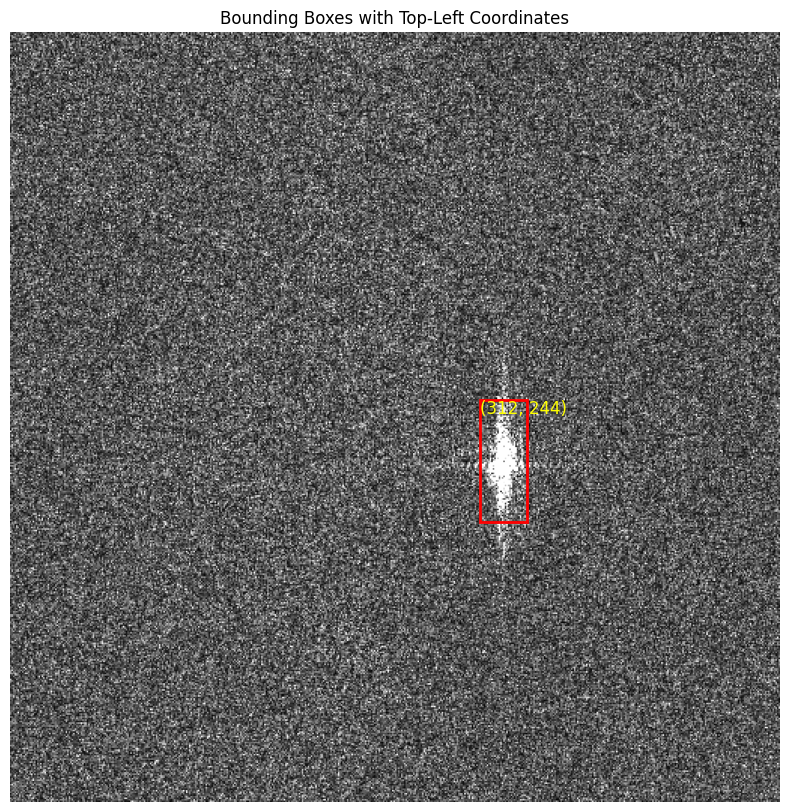

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the new image
new_image_path_4 = "/mnt/d/patches/2024-10-13-01-50-32_UMBRA-08_SICD_MM_462_5544_974_6056.tif"
new_image_4 = Image.open(new_image_path_4)
new_image_width_4, new_image_height_4 = new_image_4.size

# Parse the new YOLO format txt file
new_yolo_data_path_4 = "/mnt/d/patches/2024-10-13-01-50-32_UMBRA-08_SICD_MM_462_5544_974_6056.txt"
with open(new_yolo_data_path_4, "r") as file:
    new_yolo_data_4 = file.readlines()

# Parse the bounding box data
new_bboxes_4 = []
for line in new_yolo_data_4:
    label, x_center, y_center, width, height = line.strip().split()
    x_center, y_center, width, height = float(x_center), float(y_center), float(width), float(height)
    
    # Convert from YOLO format to bounding box coordinates
    x_min = int((x_center - width / 2) * new_image_width_4)
    y_min = int((y_center - height / 2) * new_image_height_4)
    x_max = int((x_center + width / 2) * new_image_width_4)
    y_max = int((y_center + height / 2) * new_image_height_4)
    
    new_bboxes_4.append((x_min, y_min, x_max, y_max))

# Plot the new image with bounding boxes and labels
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_image_4, cmap='gray')

# Draw bounding boxes with labels
for bbox in new_bboxes_4:
    x_min, y_min, x_max, y_max = bbox
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    # Label the top-left corner with the coordinates
    ax.text(x_min, y_min, f"({x_min}, {y_min})", color='yellow', fontsize=12, verticalalignment='top')

ax.set_title('Bounding Boxes with Top-Left Coordinates')
ax.axis('off')
plt.show()

In [18]:
import json

# Load the JSON data
input_file_path = "/mnt/d/dataset/depth.json"
output_file_path = "/mnt/d/dataset/depth2.json"

with open(input_file_path, 'r') as file:
    data = json.load(file)

# Update the "id" values
for i, annotation in enumerate(data['annotations'], start=1):
    annotation['id'] = i

# Save the modified JSON data
with open(output_file_path, 'w') as file:
    json.dump(data, file, indent=4)

print("The JSON file has been updated and saved successfully.")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
The JSON file has been updated and saved successfully.


In [19]:
import json

# Load the JSON file
input_file_path = "/mnt/d/dataset/depth.json"#"/mnt/d/dataset/moving.json"
output_file_path = "/mnt/d/dataset/depth2.json"#'/mnt/d/dataset/moving2.json'

with open(input_file_path, 'r') as f:
    data = json.load(f)

# Map class IDs to class names
# Note: Replace the class_map dictionary with the actual class mapping from your dataset
# class_map = {
#     1: "Helicopter",
#     2: "Transport plane",
#     3: "Fighterairplane",
#     4: "Airplane1",
#     5: "Airplane2",
#     6: "Ambiguous",
#     7: "Warship",
#     8: "movingairplane"
#     # Add other class mappings as needed
# }
class_map = {1:"person"}
# Update annotations to include the 'caption' key 
for annotation in data['annotations']:
    class_id = annotation['category_id']
    if class_id in class_map:
        annotation['caption'] = class_map[class_id] ##adding caption
    else:
        annotation['caption'] = 'unknown'

# Save the updated JSON file
with open(output_file_path, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Updated JSON file saved to {output_file_path}")

Updated JSON file saved to /mnt/d/dataset/depth2.json


In [2]:
files = glob.glob('/mnt/d/dataset/for_split2/*.txt')#('/mnt/d/dataset/uu/*.txt')

In [2]:
import os

folder_path = '/mnt/e/snu/2024/민군/data/'

# Get the list of all .tif and .txt files
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Sort the files in alphabetical order
tif_files.sort()
txt_files.sort()

# Rename the files with sequential numbers
for i in range(len(tif_files)):
    tif_file_path = os.path.join(folder_path, tif_files[i])
    txt_file_path = os.path.join(folder_path, txt_files[i])
    
    new_tif_file_name = f'{i+1:03}.tif'
    new_txt_file_name = f'{i+1:03}.txt'
    
    new_tif_file_path = os.path.join(folder_path, new_tif_file_name)
    new_txt_file_path = os.path.join(folder_path, new_txt_file_name)
    
    os.rename(tif_file_path, new_tif_file_path)
    os.rename(txt_file_path, new_txt_file_path)

In [91]:
import cv2
import numpy as np

def read_yolo_file(file_path):
    image_path = file_path.replace('txt', 'tif')
    image = cv2.imread(image_path)
    i_width, i_height = int(image.shape[1]), int(image.shape[0])
    print(i_width);print(i_height)
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    boxes = []
    for line in lines:
        line = line.strip().split()
        #print(line)
        class_id = line[0]
        x_center = float(line[1])
        y_center = float(line[2])
        width = float(line[3])
        height = float(line[4])
        print(x_center);print(y_center);print(width);print(height)
        x_min = int((x_center - width/2) * i_width)
        y_min = int((y_center - height/2) * i_height)
        x_max = int((x_center + width/2) * i_width)
        y_max = int((y_center + height/2) * i_height)
        boxes.append((class_id, x_min, y_min, x_max, y_max))
    
    return boxes

def draw_bounding_boxes(image_path, boxes):
    image = cv2.imread(image_path)
    
    for box in boxes:
        class_id, x_min, y_min, x_max, y_max = box
        color = (0, 255, 0)  # Green color for bounding box
        thickness = 5
        
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    
    return image

def write_image(image_path, image):
    cv2.imwrite(image_path, image)

In [98]:
t_files = glob.glob('/mnt/d/dataset/tttt/test/*.txt')
tif_files = glob.glob('/mnt/d/dataset/tttt/test/*.tif')

In [99]:
t_files

['/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_0_7000_7000_2884_2060_3396_2572.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_0_7000_7000_3296_3296_3808_3808.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_0_7000_7000_3708_6180_4220_6692.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_0_7000_7000_5768_6180_6280_6692.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_6500_7000_13500_1648_0_2160_512.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_6500_7000_13500_2060_6180_2572_6692.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_6500_7000_13500_2472_2884_2984_3396.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_6500_7000_13500_2472_6180_2984_6692.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_6500_7000_13500_2884_6180_3396_6692.txt',
 '/mnt/d/dataset/tttt/test/2023-06-05-10-10-15_UMBRA-06_0_6500_7000_13500_3296_1236_3808_1748.txt',
 '/mnt/d/dataset/ttt

In [100]:
for i in range(len(t_files)):
    txt_file_path = t_files[i]
    tif_file_path = tif_files[i]
    # Read YOLO file
    boxes = read_yolo_file(txt_file_path)
    print(boxes)
    # Draw bounding boxes on TIFF image
    image = draw_bounding_boxes(tif_file_path, boxes)

    # Write the image with bounding boxes
    output_image_path = tif_file_path
    write_image(output_image_path, image)

512
512
[]
512
512
[]
512
512
0.768555
0.641602
0.462891
0.474609
[('Airplane1', 275, 207, 512, 450)]
512
512
[]
512
512
[]
512
512
0.897461
0.714844
0.205078
0.257812
[('movingairplane', 407, 300, 512, 432)]
512
512
[]
512
512
0.5
0.714844
1.0
0.257812
[('movingairplane', 0, 300, 512, 432)]
512
512
0.5
0.714844
1.0
0.257812
[('movingairplane', 0, 300, 512, 432)]
512
512
0.496094
0.273438
0.257812
0.285156
[('Airplane1', 188, 67, 320, 213)]
512
512
0.664062
0.84375
0.398438
0.3125
[('Airplane2', 237, 352, 441, 512)]
512
512
0.664062
0.140625
0.398438
0.28125
[('Airplane2', 237, 0, 441, 144)]
512
512
0.5
0.714844
1.0
0.257812
[('movingairplane', 0, 300, 512, 432)]
512
512
0.482422
0.217773
0.226562
0.240234
[('Airplane2', 189, 49, 304, 172)]
512
512
0.5
0.714844
1.0
0.257812
[('movingairplane', 0, 300, 512, 432)]
512
512
0.664062
0.708984
0.316406
0.304688
0.868164
0.357422
0.263672
0.304688
[('Airplane2', 258, 284, 420, 440), ('Airplane2', 376, 104, 512, 261)]
512
512
0.556641
0.873047

In [3]:
## 파일명에 .tif 중복될때 제거용

# 폴더 경로 설정
folder_path = '/mnt/d/dataset/for_split2'

# 1. 폴더 내에서 .txt 형식의 파일을 찾는다.
for file in os.listdir(folder_path):
    if file.endswith('.txt'):
        # 2. 찾은 파일 이름에 .tif가 있다면 파일 이름에서 .tif를 지워서 rename한다.
        new_name = file.replace('.tif', '', 1)
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, new_name))

# 3. 폴더 내에서 .tif 파일을 찾는다.
for file in os.listdir(folder_path):
    if file.endswith('.tif'):
        # 4. 폴더 내에서 찾은 .tif파일의 이름 중 첫번째로 나온 .tif를 지우고 파일이름을 rename해준다.
        new_name = file.replace('.tif', '', 1)
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, new_name))

In [101]:
# Get the list of all .txt and .tif files
txt_files = glob.glob('/mnt/e/detect_target/data/umbra_split/*.txt')
tif_files = [f.replace('.txt', '.tif') for f in txt_files]

# Split the files into two sets for class labels proportion use stratify
txt_train, txt_test, tif_train, tif_test = train_test_split(txt_files, tif_files, test_size=0.3,random_state=1004)

# Create directories for the train and test sets
os.makedirs('/mnt/e/detect_target/data/train', exist_ok=True)#'/mnt/d/dataset/images/umbra/train'
os.makedirs('/mnt/e/detect_target/data/validation', exist_ok=True)#'/mnt/d/dataset/images/umbra/valid'

# Move the files to the corresponding directories
for file in txt_train + tif_train:
    shutil.copy(file, '/mnt/e/detect_target/data/train')

for file in txt_test + tif_test:
    shutil.copy(file, '/mnt/e/detect_target/data/validation')

In [4]:
# Get the list of all .txt and .tif files
txt_files = glob.glob('/mnt/e/detect_target/data/train/*.txt')
tif_files = [f.replace('.txt', '.tif') for f in txt_files]

# Split the files into two sets for class labels proportion use stratify
txt_train, txt_test, tif_train, tif_test = train_test_split(txt_files, tif_files, test_size=0.4,random_state=1004)

# Create directories for the train and test sets
os.makedirs('/mnt/e/detect_target/data/gligen_data/train', exist_ok=True)#'/mnt/d/dataset/images/umbra/train'
os.makedirs('/mnt/e/detect_target/data/gligen_data/infer', exist_ok=True)#'/mnt/d/dataset/images/umbra/valid'

# Move the files to the corresponding directories
for file in txt_train + tif_train:
    shutil.copy(file, '/mnt/e/detect_target/data/gligen_data/train')

for file in txt_test + tif_test:
    shutil.copy(file, '/mnt/e/detect_target/data/gligen_data/infer')

In [102]:
# Get the list of all .txt and .tif files
txt_files = glob.glob('/mnt/e/detect_target/data/validation/*.txt')
tif_files = [f.replace('.txt', '.tif') for f in txt_files]

# Split the files into two sets for class labels proportion use stratify
txt_train, txt_test, tif_train, tif_test = train_test_split(txt_files, tif_files, test_size=0.4,random_state=1004)

# Create directories for the train and test sets
os.makedirs('/mnt/e/detect_target/data/valid', exist_ok=True)#'/mnt/d/dataset/images/umbra/train'
os.makedirs('/mnt/e/detect_target/data/test', exist_ok=True)#'/mnt/d/dataset/images/umbra/valid'

# Move the files to the corresponding directories
for file in txt_train + tif_train:
    shutil.copy(file, '/mnt/e/detect_target/data/valid')

for file in txt_test + tif_test:
    shutil.copy(file, '/mnt/e/detect_target/data/test')

In [12]:
import os

dir_path = "/mnt/d/dataset/for_split"  # replace with your directory path

for file_name in os.listdir(dir_path):
    if file_name.endswith('.tif'):
        new_file_name = file_name.replace('.tif', '', 1)
        if not new_file_name.endswith('.tif'):
            new_file_name += '.tif'
        os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))
    elif file_name.endswith('.txt'):
        new_file_name = file_name.replace('.txt', '', 1)
        if not new_file_name.endswith('.txt'):
            new_file_name += '.txt'
        os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))

In [11]:
import os

dir_path = "/mnt/d/dataset/for_split"  # replace with your directory path

for file_name in os.listdir(dir_path):
    if file_name.endswith('.tif'):
        new_file_name = file_name.replace('.tif', '', 1) + '.tif'
        os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))
    elif file_name.endswith('.txt'):
        new_file_name = file_name.replace('.tif', '', 1) + '.txt'
        os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))

In [3]:
keys = [0, 1, 2, 3, 4, 5, 6,7]
values = ['Helicopter', 'Transportplane', 'Fighterairplane', 'Airplane1', 'Airplane2', 'Ambiguous', 'Warship','movingairplane']
labels = dict(zip(keys, values))

In [5]:
labels2 = dict(zip(values,keys))

In [6]:
labels2['Helicopter']

0

In [9]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import cv2

In [69]:
def Upload_rimg(file_path):
    with open(file_path, 'rb') as f:
        # Read the metadata (dimensions)
        width, height = struct.unpack('QQ', f.read(16))
        # Initialize an array to hold the range image data
        range_image = np.zeros((height, width), dtype=np.float16)
        
        # Read the range image data
        for row in range(height):
            for col in range(width):
                # Read 2 bytes (float16) and convert to float
                range_image[row, col] = np.frombuffer(f.read(2), dtype=np.float16)[0]
    
    return range_image


def max_pooling(image, kernel_size, stride):
    """
    Apply max pooling to the input image.

    Parameters:
    image (numpy.ndarray): The input image.
    kernel_size (int): The size of the pooling window.
    stride (int): The stride of the pooling operation.

    Returns:
    numpy.ndarray: The pooled image.
    """
    # Get the dimensions of the input image
    (h, w) = image.shape[:2]

    # Calculate the dimensions of the output image
    out_h = (h - kernel_size) // stride + 1
    out_w = (w - kernel_size) // stride + 1

    # Initialize the output image
    pooled_image = np.zeros((out_h, out_w), dtype=image.dtype)

    # Perform max pooling
    for y in range(0, h - kernel_size + 1, stride):
        for x in range(0, w - kernel_size + 1, stride):
            window = image[y:y + kernel_size, x:x + kernel_size]
            pooled_image[y // stride, x // stride] = np.max(window)

    return pooled_image

def contrast_stretching(array, newMin=0, newMax=0.3):

    array_2 = np.nan_to_num(array, nan=0)
    array_2[array_2<=newMin] = newMin
    array_2[array_2>=newMax] = newMax

    result = (array_2 - newMin) / (newMax - newMin) * 255

    return result

In [96]:
pooled_image = max_pooling(dd, kernel_size=3, stride=1)

In [57]:
pooled_image.shape

(214, 382)

In [72]:
dd2 = contrast_stretching(dd, 0,dd.max())
dd2.dtype= np.uint8

In [4]:
import os
file_path = "/mnt/d/yolov5/runs/detect/exp6/labels/chile3_2700_8100_3340_8740.txt"

# Extract the file name from the file path
file_name = os.path.basename(file_path)

# Split the file name by underscores
split_name = file_name.split('_')

# Extract the values for start_x and start_y
start_x = int(split_name[1])
start_y = int(split_name[2])

# Print the values
print("start_x:", start_x)
print("start_y:", start_y)

start_x: 2700
start_y: 8100


In [1]:
import os
import glob
import torch
from torchvision.ops import nms

def make_origin_bbox(bbox, img_size, start_x, start_y):
    x_center, y_center, width, height = bbox
    
    # YOLO 형식에서 (x_center, y_center, width, height)를 (x1, y1, x2, y2)로 변환
    x1 = (x_center - width / 2) * img_size + start_x
    y1 = (y_center - height / 2) * img_size + start_y
    x2 = (x_center + width / 2) * img_size + start_x
    y2 = (y_center + height / 2) * img_size + start_y
    
    return [x1, y1, x2, y2]

def extract_startx_starty(path):
    file_name = os.path.basename(path)

    # Split the file name by underscores
    split_name = file_name.split('_')

    # Extract the values for start_x and start_y
    start_x = int(split_name[1])
    start_y = int(split_name[2])
    return start_x, start_y

In [21]:
annotations = []
conf_list = []
imgsz=640
files = glob.glob('/mnt/d/yolov5/runs/detect/exp5/labels/*.txt')

for f in files:
    # img = "/mnt/d/yolov5/test/test_img/"+os.path.basename(f.replace('labels', 'images').replace('.txt', '.tif'))
    # img = cv2.imread(img);img_size = img.shape[0]
    # Open the file in read mode
    with open(f, 'r') as file:
        # Read the contents of the file
        contents = file.readlines()

    # Initialize a list to store the modified lines

    start_x, start_y = extract_startx_starty(f)

    # Iterate over each line in the file
    for line in contents:
        # Split the line by whitespace
        line_parts = line.split()

        # Extract the bounding box coordinates
        bbox = list(map(float, line_parts[1:5]))

        # Apply make_origin_bbox to get the modified bounding box coordinates
        modified_bbox = make_origin_bbox(bbox, imgsz, start_x, start_y)
        
        annotations.append(torch.tensor([modified_bbox[0],modified_bbox[1],modified_bbox[2],modified_bbox[3]]).reshape(-1,4))
        conf_list.append(float(line_parts[5]))
        #print(conf_list)
        # Convert the modified bounding box coordinates back to string
        modified_bbox_str = ' '.join(map(str, modified_bbox))

        # Replace the original bounding box coordinates with the modified ones
        modified_line = f"{line_parts[0]} {modified_bbox_str}\n"
        
concated_annotations = torch.cat(annotations, dim=0).float()
list_score = torch.tensor(conf_list).flatten().float()


In [22]:
after_indices = nms(concated_annotations, list_score, 0.1)
concated_annotations = concated_annotations[after_indices]
list_score = list_score[after_indices]
#list_label = list_label[after_indices]

In [15]:
html_colors = ["#3d3df5", "#46e026", "#fa3253"] #"#ffcc33", "#ff00cc", "#aaf0d1",'#034203','#B18A01'] # the color of label
colors = []

for color_code in html_colors:
    # Convert the color code to an RGB tuple of integers
    r, g, b = tuple(int(color_code[i:i+2], 16) for i in (1, 3, 5))
    colors.append((r, g, b))

keys = [0, 1, 2, 3, 4, 5, 6, 7,8]
values = ['Airplane1', 'Airplane2','movingairplane']#['Helicopter', 'Transport plane', 'Fighter airplane', 'Airplane1', 'Airplane2', 'Ambiguous','Warship','movingairplane']
colo= [0,1,2,3,4,5,6,7]
labels_l = dict(zip(keys, values))
colorbar = dict(zip(keys, colo))

In [24]:
with open('/mnt/d/yolov5/runs/detect/test.txt', 'w') as tt:
    for annotation, s in zip(concated_annotations,list_score):
        left,top,right,bottom = annotation; class_id = 1

        print(b)
        tt.write(f"{name} {labels_l[int(class_id)]} {left} {top} {right} {bottom} {s}\n")
        cv2.rectangle(vis_image, (int(left), int(top)), (int(right), int(bottom)), colors[colorbar[int(class_id)]],4)
        cv2.putText(vis_image, str(left), (int(left),int(top-5)), cv2.FONT_ITALIC, 0.3,(255,255,255),1)

cv2.imwrite('/mnt/d/yolov5/test/test_result' +'_detect'+'.png', vis_image)

83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83


True

In [5]:

file_name = os.path.basename('/mnt/d/yolov5/runs/detect/exp6/labels/2023-07-29-13-37-04_UMBRA-05_GEC_10260_2700_10900_3340.txt')

# Split the file name by underscores
split_name = file_name.split('_GEC')

# # Extract the values for start_x and start_y
# start_x = int(split_name[1])
# start_y = int(split_name[2])

In [8]:
import re

file_path = '/mnt/d/yolov5/runs/detect/exp6/labels/2023-07-29-13-37-04_UMBRA-05_GEC_10260_2700_10900_3340.txt'

# 정규 표현식을 사용하여 숫자 추출
pattern = r'_(\d+)_(\d+)_'
matches = re.search(pattern, file_path)

if matches:
    num1 = matches.group(1)
    num2 = matches.group(2)
    print(f"Extracted numbers: {num1}, {num2}")
else:
    print("No matches found")

Extracted numbers: 10260, 2700


In [5]:
import torch
import torchvision.ops
from torch import nn
import numpy as np
import cv2
import time
from osgeo import gdal, osr
import os
import argparse
from torchvision.ops import nms
import glob
import re
html_colors = ["#3d3df5", "#46e026", "#fa3253"] #"#ffcc33", "#ff00cc", "#aaf0d1",'#034203','#B18A01'] # the color of label
colors = []

for color_code in html_colors:
    # Convert the color code to an RGB tuple of integers
    r, g, b = tuple(int(color_code[i:i+2], 16) for i in (1, 3, 5))
    colors.append((r, g, b))

keys = [0, 1, 2, 3, 4, 5, 6, 7,8]
values = ['Airplane1', 'Airplane2','movingairplane']#['Helicopter', 'Transport plane', 'Fighter airplane', 'Airplane1', 'Airplane2', 'Ambiguous','Warship','movingairplane']
colo= [0,1,2,3,4,5,6,7]
labels_l = dict(zip(keys, values))
colorbar = dict(zip(keys, colo))
start = time.time()

def make_origin_bbox(bbox, img_size, start_x, start_y):
    x_center, y_center, width, height = bbox
    
    # YOLO 형식에서 (x_center, y_center, width, height)를 (x1, y1, x2, y2)로 변환
    x1 = (x_center - width / 2) * img_size + start_x
    y1 = (y_center - height / 2) * img_size + start_y
    x2 = (x_center + width / 2) * img_size + start_x
    y2 = (y_center + height / 2) * img_size + start_y
    
    return [x1, y1, x2, y2]

def extract_startx_starty(path):
    pattern = r'_(\d+)_(\d+)_'
    matches = re.search(pattern, path)

    if matches:
        start_x = matches.group(1)
        start_y = matches.group(2)
        #print(f"Extracted numbers: {start}, {num2}")
    else:
        print("No matches found")
    # file_name = os.path.basename(path)

    # # Split the file name by underscores
    # split_name = file_name.split('_')

    # # Extract the values for start_x and start_y
    # start_x = int(split_name[1])
    # start_y = int(split_name[2])
    return float(start_x), float(start_y)

annotations = []
conf_list = []
imgsz=640
#D:\yolov5\runs\detect\exp6\labels
files = glob.glob('/mnt/d/yolov5/runs/detect/exp6/labels/*.txt')

for f in files:
    # img = "/mnt/d/yolov5/test/test_img/"+os.path.basename(f.replace('labels', 'images').replace('.txt', '.tif'))
    # img = cv2.imread(img);img_size = img.shape[0]
    # Open the file in read mode
    with open(f, 'r') as file:
        # Read the contents of the file
        contents = file.readlines()

    # Initialize a list to store the modified lines

    start_x, start_y = extract_startx_starty(f)

    # Iterate over each line in the file
    for line in contents:
        # Split the line by whitespace
        line_parts = line.split()

        # Extract the bounding box coordinates
        bbox = list(map(float, line_parts[1:5]))

        # Apply make_origin_bbox to get the modified bounding box coordinates
        modified_bbox = make_origin_bbox(bbox, imgsz, start_x, start_y)
        
        annotations.append(torch.tensor([modified_bbox[0],modified_bbox[1],modified_bbox[2],modified_bbox[3]]).reshape(-1,4))
        conf_list.append(float(line_parts[5]))
        #print(conf_list)
        # Convert the modified bounding box coordinates back to string
        modified_bbox_str = ' '.join(map(str, modified_bbox))

        # Replace the original bounding box coordinates with the modified ones
        modified_line = f"{line_parts[0]} {modified_bbox_str}\n"
        
concated_annotations = torch.cat(annotations, dim=0).float()
list_score = torch.tensor(conf_list).flatten().float()

after_indices = nms(concated_annotations, list_score, 0.1)
concated_annotations = concated_annotations[after_indices]
list_score = list_score[after_indices]
name = '00'
vis_image = cv2.imread("/mnt/d/yolov5/2023-07-29-13-37-04_UMBRA-05/2023-07-29-13-37-04_UMBRA-05_GEC.tif")#"D:\yolov5\2023-07-29-13-37-04_UMBRA-05\2023-07-29-13-37-04_UMBRA-05_GEC.tif"
with open('/mnt/d/yolov5/runs/detect/test.txt', 'w') as tt:
    for annotation, s in zip(concated_annotations,list_score):
        left,top,right,bottom = annotation; class_id = 1

        print(b)
        tt.write(f"{name} {labels_l[int(class_id)]} {left} {top} {right} {bottom} {s}\n")
        cv2.rectangle(vis_image, (int(left), int(top)), (int(right), int(bottom)), colors[colorbar[int(class_id)]],4)
        cv2.putText(vis_image, str(s), (int(left),int(top-5)), cv2.FONT_ITALIC, 0.3,(255,255,255),1)

cv2.imwrite('/mnt/d/yolov5/test/test_result' +'chile0729_detect'+'.png', vis_image)

83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83


True

In [132]:
from PIL import Image
import glob

# 이미지 파일이 위치한 경로
image_path = '/mnt/e/detect_target/mmdeploy/coco/test2017/images/*.tif'

# 해당 경로의 모든 .tif 파일을 찾음
tif_files = glob.glob(image_path)

# 각 이미지 파일에 대해
for file in tif_files:
    # 이미지를 열고
    with Image.open(file) as img:
        # 이미지의 사이즈를 확인
        if img.size != (512, 512):
            # 이미지가 512x512가 아니면 리사이즈
            resized_img = img.resize((512, 512), Image.Resampling.LANCZOS)
            # 원본 이미지에 덮어쓰기
            resized_img.save(file)
            print(f"Resized and overwritten: {file}")
        else:
            # 이미지 사이즈가 이미 512x512인 경우
            print(f"{file} is already 512x512.")

/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_1648_4532_2160_5044.tif is already 512x512.
/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_2472_3708_2984_4220.tif is already 512x512.
/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_2472_5356_2984_5868.tif is already 512x512.
/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_3708_4944_4220_5456.tif is already 512x512.
/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_5356_412_5868_924.tif is already 512x512.
/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_5356_6180_5868_6692.tif is already 512x512.
/mnt/e/detect_target/mmdeploy/coco/test2017/images/2023-02-01-03-05-24_UMBRA-04_GEC_0_0_7000_7000_5768_6180_6280_6692.tif is already 512x512.
/mnt/e/d

In [ ]:
import cv2
import os
import glob

def draw_bboxes(image_path, txt_path, output_path):
    # 이미지 로드
    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    # txt 파일 열기
    with open(txt_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        # YOLO 형식: class_id x_center y_center width height
        class_id, x_center, y_center, width, height = map(float, line.split())

        # 좌표 변환 (YOLO 형식을 이미지 좌표로 변환)
        x_center *= w
        y_center *= h
        width *= w
        height *= h

        # 좌표 계산
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # bounding box 그리기
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 녹색 박스, 두께 2

    # 이미지 저장
    cv2.imwrite(output_path, image)
    print(f"Image saved to {output_path}")


: 